<a href="https://colab.research.google.com/github/AndrewBoessen/CSCI3387_Notebooks/blob/main/Skiing_RL_DAgger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Setup gym env
!pip install gymnasium<1.0.0
!pip install "gymnasium[atari, accept-rom-license]<1.0.0"
!pip install torchinfo

/bin/bash: line 1: 1.0.0: No such file or directory


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import gymnasium as gym

from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
import datetime

env_name = "ALE/Skiing-v5"
env = gym.make(env_name, render_mode="rgb_array")

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


In [3]:
def render(x, step=0):
    display.clear_output(wait=True)
    plt.figure(figsize=(6, 6))
    plt.clf()
    plt.axis("off")
    plt.title(f"step: {step}")
    plt.imshow(x, cmap=plt.cm.gray)
    plt.pause(0.001)

def pre_processing(observe):
    from skimage.transform import resize
    return resize(observe[54:-52,8:152], (64, 64), mode='reflect', anti_aliasing=True)

def batch(obss, acts, batch_size=32):
    n_data = len(obss)
    ids = np.random.choice(n_data, batch_size, replace=False)
    b_o = obss[ids]
    b_a = acts[ids]
    return torch.FloatTensor(b_o), torch.LongTensor(b_a)

def get_pos_player(observe):
    ids = np.where(np.sum(observe == [214, 92, 92], -1) == 3)
    return ids[0].mean(), ids[1].mean()

def get_pos_flags(observe):
    if np.any(np.sum(observe == [184, 50, 50], -1) == 3):
        ids = np.where(np.sum(observe == [184, 50, 50], -1) == 3)
        return ids[0].mean(), ids[1].mean()
    else:
        base = 0
        ids = np.where(np.sum(observe[base:-60] == [66, 72, 200], -1) == 3)
        return ids[0].mean() + base, ids[1].mean()

def get_speed(observe, observe_old):
    min_val = np.inf
    min_idx = 0
    for k in range(0, 7):
        val = np.sum(np.abs(observe[54:-52,8:152] - observe_old[54+k:-52+k,8:152]))
        if min_val > val:
            min_idx = k
            min_val = val
    return min_idx

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3*n_cont, 16, 8, stride=4)
        self.conv2 = nn.Conv2d(16, 32, 4, stride=2)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 3)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.reshape(x, (-1, 64 * 4 * 4))
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

n_cont = 4
obss = np.empty((0, 64, 64, 3*n_cont))
acts = np.empty((0))

model = PolicyNetwork()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [41]:
summary(model)

Layer (type:depth-idx)                   Param #
PolicyNetwork                            --
├─Conv2d: 1-1                            12,304
├─Conv2d: 1-2                            8,224
├─Conv2d: 1-3                            18,496
├─Linear: 1-4                            524,800
├─Linear: 1-5                            1,539
Total params: 565,363
Trainable params: 565,363
Non-trainable params: 0

In [42]:
# Initialize TensorBoard writer
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f'runs/skiing_agent_{current_time}'
writer = SummaryWriter(log_dir)

# Main training loop
for episode in tqdm(range(1000), desc="Episodes"):
    observe, _ = env.reset()
    step = 0
    cnt = 0
    done = False
    r_a, c_a = get_pos_player(observe)
    r_f, c_f = get_pos_flags(observe)
    r_a_old, c_a_old = r_a, c_a
    observe_old = observe
    history = np.concatenate([pre_processing(observe)] * n_cont, -1)

    outs_o = []
    outs_a = []
    episode_reward = 0

    while not done:
        step += 1

        # TEACHER
        v_f = np.arctan2(r_f - r_a, c_f - c_a)
        spd = get_speed(observe, observe_old)
        v_a = np.arctan2(spd, c_a - c_a_old)
        r_a_old, c_a_old = r_a, c_a
        observe_old = observe
        if spd == 0 and (c_a - c_a_old) == 0:
            cnt += 1
            act_t = np.random.choice(3, 1)[0]
        else:
            cnt = 0
            if v_f - v_a < -0.1:
                act_t = 1
            elif v_f - v_a > 0.1:
                act_t = 2
            else:
                act_t = 0

        if cnt > 10:
            print('no movement!')
            break

        outs_o.append(history)
        outs_a.append(act_t)

        with torch.no_grad():
            model_output = model(torch.FloatTensor(history).unsqueeze(0).permute(0, 3, 1, 2))
            p = torch.softmax(model_output, dim=-1)[0]
        act = np.random.choice(3, 1, p=p.numpy())[0]
        observe, reward, terminated, truncated, info = env.step(act)
        done = terminated or truncated
        episode_reward += reward
        history = np.concatenate([pre_processing(observe), history[:,:,3:]], -1)
        r_a, c_a = get_pos_player(observe)
        r_f, c_f = get_pos_flags(observe)

        obss = np.concatenate([obss, outs_o], 0)
        acts = np.concatenate([acts, outs_a], 0)
        if len(obss) > 5000:
            obss = obss[-5000:]
            acts = acts[-5000:]

    # Training step
    total_loss = 0
    for i in tqdm(range(500), desc=f"Training (Episode {episode})", leave=False):
        d_x, d_y = batch(obss, acts)
        optimizer.zero_grad()
        output = model(d_x.permute(0, 3, 1, 2))
        loss = criterion(output, d_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / 500

    # Log to TensorBoard
    writer.add_scalar('Training/Average Loss', avg_loss, episode)
    writer.add_scalar('Training/Episode Reward', episode_reward, episode)
    writer.add_scalar('Training/Episode Length', step, episode)

    tqdm.write(f"Episode {episode}: Avg Loss: {avg_loss:.4f}, Reward: {episode_reward}, Steps: {step}")

# Close the TensorBoard writer
writer.close()

Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-4170b6af173e>:32: RuntimeWarning: Mean of empty slice.
  return ids[0].mean() + base, ids[1].mean()


no movement!


Training (Episode 0):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 0: Avg Loss: 0.2938, Reward: -1198.0, Steps: 181
no movement!


Training (Episode 1):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 1: Avg Loss: 0.6327, Reward: -260.0, Steps: 40
no movement!


Training (Episode 2):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 2: Avg Loss: 0.8008, Reward: -233.0, Steps: 36
no movement!


Training (Episode 3):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 3: Avg Loss: 0.7097, Reward: -293.0, Steps: 45
no movement!


Training (Episode 4):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 4: Avg Loss: 0.7084, Reward: -606.0, Steps: 92
no movement!


Training (Episode 5):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 5: Avg Loss: 0.7636, Reward: -366.0, Steps: 56
no movement!


Training (Episode 6):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 6: Avg Loss: 0.6835, Reward: -533.0, Steps: 81
no movement!


Training (Episode 7):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 7: Avg Loss: 0.5380, Reward: -639.0, Steps: 97
no movement!


Training (Episode 8):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 8: Avg Loss: 0.4856, Reward: -346.0, Steps: 53
no movement!


Training (Episode 9):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 9: Avg Loss: 0.3337, Reward: -712.0, Steps: 108
no movement!


Training (Episode 10):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 10: Avg Loss: 0.5609, Reward: -406.0, Steps: 62
no movement!


Training (Episode 11):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 11: Avg Loss: 0.4040, Reward: -825.0, Steps: 125
no movement!


Training (Episode 12):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 12: Avg Loss: 0.4470, Reward: -266.0, Steps: 41
no movement!


Training (Episode 13):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 13: Avg Loss: 0.6355, Reward: -386.0, Steps: 59
no movement!


Training (Episode 14):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 14: Avg Loss: 0.7956, Reward: -479.0, Steps: 73
no movement!


Training (Episode 15):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 15: Avg Loss: 0.6585, Reward: -373.0, Steps: 57
no movement!


Training (Episode 16):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 16: Avg Loss: 0.7633, Reward: -399.0, Steps: 61
no movement!


Training (Episode 17):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 17: Avg Loss: 0.5111, Reward: -1065.0, Steps: 161
no movement!


Training (Episode 18):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 18: Avg Loss: 0.4781, Reward: -260.0, Steps: 40
no movement!


Training (Episode 19):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 19: Avg Loss: 0.6011, Reward: -386.0, Steps: 59
no movement!


Training (Episode 20):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 20: Avg Loss: 0.2849, Reward: -892.0, Steps: 135
no movement!


Training (Episode 21):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 21: Avg Loss: 0.4438, Reward: -393.0, Steps: 60
no movement!


Training (Episode 22):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 22: Avg Loss: 0.5054, Reward: -293.0, Steps: 45
no movement!


Training (Episode 23):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 23: Avg Loss: 0.5097, Reward: -552.0, Steps: 84
no movement!


Training (Episode 24):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 24: Avg Loss: 0.6236, Reward: -606.0, Steps: 92
no movement!


Training (Episode 25):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 25: Avg Loss: 0.5657, Reward: -1551.0, Steps: 234
no movement!


Training (Episode 26):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 26: Avg Loss: 0.4724, Reward: -346.0, Steps: 53
no movement!


Training (Episode 27):   0%|          | 0/500 [00:00<?, ?it/s]

Episode 27: Avg Loss: 0.5878, Reward: -379.0, Steps: 58


KeyboardInterrupt: 

KeyboardInterrupt: 

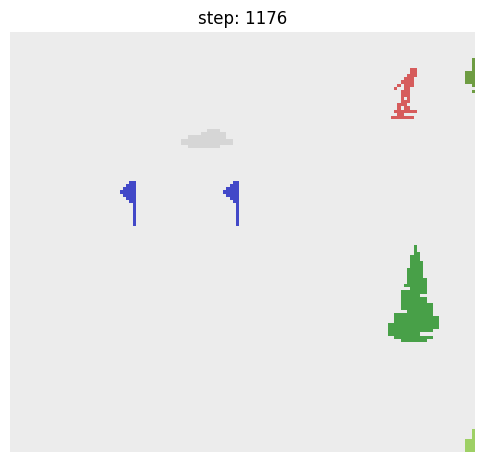

In [43]:
observe, _ = env.reset()
done = False
history = np.concatenate([pre_processing(observe)] * n_cont, -1)

tmp_obs = [observe]
while not done:
    with torch.no_grad():
        p = torch.softmax(model(torch.FloatTensor(history).unsqueeze(0).permute(0, 3, 1, 2)), dim=1)[0]
    act = np.random.choice(3, 1, p=p.numpy())[0]
    observe, reward, terminated, truncated, info = env.step(act)
    done = terminated or truncated
    history = np.concatenate([pre_processing(observe), history[:,:,3:]], -1)
    tmp_obs.append(observe)

for i, o in enumerate(tmp_obs):
    if i % 3 == 0:
        render(o[:,:,:3][28:-52,8:152], i)
render(o[:,:,:3][28:-52,8:152], i)